## Validating the posterior 

The checks are used to validate the posterior of the parameter given the data that was learned. In this case we also know the ground truth, therefore, we have the possibility the validate the predicted posterior probabilities directly as well. 

For the validation we use a testing data set, $N_{test}$ number of parameters drawn from the prior, and simulated forward to give testing data $X_{test}$. 

### MSE to ground truth posterior 
To evaluate the posterior probabilities directly we just calculate the mean squared error between the predicted and the exact posterior probabilities. For every data sample in $X_{test}$ we calculate the squared error and then we take the mean over test samples. 

### Posterior quantiles
To do the quantile checks, we perform the following steps: 
    - for every test sample obtain the posterior 
    - calculate the quantile of the corresponding test parameter in the posterior distribution 

This gives $N_{test}$ quantile values. According to the paper the distribution underlying these quantile is uniform if the posterior is accurate. A first visual test is therefore to plot the histogram of quantiles and check whether it is uniform. As a next step one could perform statistical tests to test the uniformity of the empirical quantile distribution. 

### Coverage analysis: credible intervals of the quantile distribution 
Alternatively, and somehow more Bayesian, is to check the credible intervals of the quantile distribution. To this end, we count the mass in different intervals around the mode of the distribution, or, assuming that the quantile distribution is uniform in $[0, 1]$, around 0. Then we compare this mass against the width of the interval, e.g., plot the interval against the counted mass. For a perfectly uniform distribution this would be a straight line because the mass is distributed uniformly so that it exactly matches the width of the interval. In summary: 
     - count the relative number of quantiles in intervals of $0.1, \ldots, 0.5$ arond 0 of the quantile histogram
     - plot the relative counts against the width of the interval
     
### Check $D_{KL}$ between true and predicted posterior 
One can calculate the DKL between the true and the predicted posterior and divide by the entropy of the true posterior. 

In [78]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time
import tqdm

sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel
%matplotlib inline

In [79]:
mpl_params = {'legend.fontsize': 15,
              'legend.frameon': False,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

In [80]:
folder = '../data/'
fn = '201803220946_toy_example_results_N100000M10_k21.0.p'
time_stamp = fn[:fn.find('_')]

with open(os.path.join(folder, fn), 'rb') as f: 
    d = pickle.load(f)
    
# set the seed for generating new test data 
seed = 5
np.random.seed(seed)

In [81]:
d_model = d['model_post']
d_model.keys()

dict_keys(['seed', 'trainer', 'model_models', 'x', 'm', 'xtest', 'mtest', 'sx', 'sx_test', 'training_norm', 'param_poi', 'params_nb', 'theta1', 'theta2', 'theta3', 'k1', 'k2', 'k3', 'sample_size', 'n_samples', 'ppoi_exact'])

In [82]:
model = d_model['model_models']
x = d_model['x']
sx = d_model['sx']
xtest = d_model['xtest']
mtest = d_model['mtest']
ppoi_exact = d_model['ppoi_exact']
sx_test = d_model['sx_test']
sample_size = d_model['sample_size']

training_norm = d_model['training_norm']
k1, k2, k3 = d_model['k1'], d_model['k2'], d_model['k3']
theta1, theta2, theta3 = d_model['theta1'], d_model['theta2'], d_model['theta3']

# priors 
prior_lambda = scipy.stats.gamma(a=k1, scale=theta1)
prior_k = scipy.stats.gamma(a=k2, scale=theta2)
prior_theta = scipy.stats.gamma(a=k3, scale=theta3)

model_poisson = PoissonModel(sample_size=sample_size, seed=seed)
model_nb = NegativeBinomialModel(sample_size=sample_size, seed=seed)

# First the discrete model idx posterior

## Visualize network and test samples

### Calculate grid of predictions 

In [83]:
ms, vs = np.meshgrid(np.linspace(0, 30, 100), np.linspace(0, 200, 100))
# stack values to evaluate as vector in the model 
sx_vis = np.vstack((ms.flatten(), vs.flatten())).T
# normalize 
sx_vis, training_norm = normalize(sx_vis, training_norm)


# predict probs 
ppoi_vec = model.predict(sx_vis)
# take poisson posterior prob and reshape to grid dimensions
ppoi_vismat = ppoi_vec[:, 0].reshape(ms.shape[0], vs.shape[0])

### Plot exact posterior probs on top

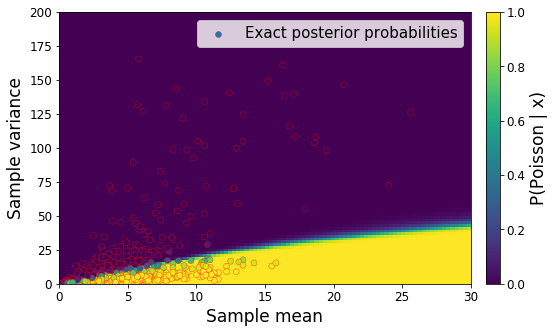

In [84]:
plt.figure(figsize=(9, 5))
cnorm = mpl.colors.Normalize(vmin=ppoi_vismat.min(), vmax=ppoi_vismat.max())
cmap = plt.cm.viridis

plt.scatter(x=sx_test[:, 0], y=sx_test[:, 1], c=np.array(ppoi_exact), cmap=cmap, norm=cnorm, edgecolors='r', linewidths=0.3)

plt.imshow(ppoi_vismat, origin='lower', aspect='auto', 
           norm=cnorm, cmap=cmap, extent=[ms.min(), ms.max(), vs.min(), vs.max()])

plt.xlabel('Sample mean')
plt.ylabel('Sample variance')
plt.colorbar(label='P(Poisson | x)', pad=0.03)
plt.legend(['Exact posterior probabilities'], frameon=True);

# MSE 

In [85]:
sx_test_zt, training_norm = normalize(sx_test, training_norm)
ppoi_hat = model.predict(sx_test_zt)[:, 0]
mse = np.mean(np.abs(ppoi_hat - ppoi_exact))
print('MAE', mse)

MAE 0.0746204110882


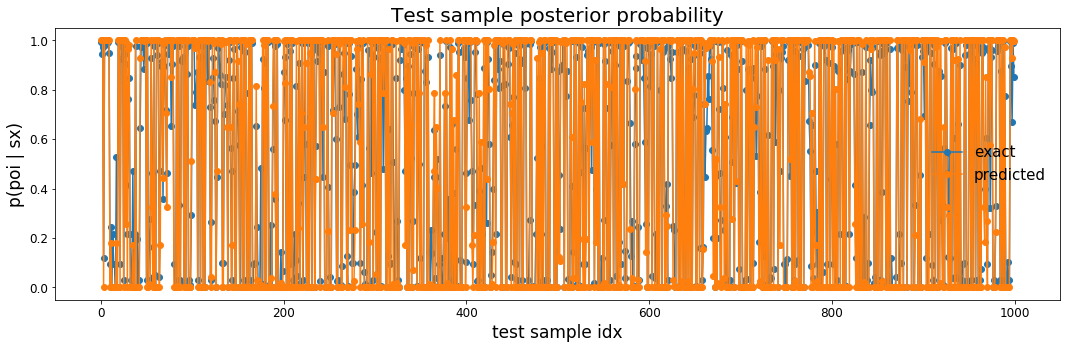

In [86]:
plt.figure(figsize=(18, 5))
plt.plot(ppoi_exact, 'o-', label='exact')
plt.plot(ppoi_hat, 'o-', label='predicted');
plt.title('Test sample posterior probability')
plt.legend()
plt.xlabel('test sample idx')
plt.ylabel('p(poi | sx)');

# Quantiles
### first generate more test data 

In [87]:
ntest = 1000

params_poi = prior_lambda.rvs(size=int(ntest / 2))
params_nb = np.vstack((prior_k.rvs(size=int(ntest / 2)), 
                       prior_theta.rvs(size=int(ntest / 2)))).T

data_poi = model_poisson.gen(params_poi)
data_nb = model_nb.gen(params_nb)

x_test = np.vstack((data_poi, data_nb))
m_test = np.hstack((np.zeros(data_poi.shape[0]), np.ones(data_nb.shape[0]))).squeeze().astype(int)
sx_test = calculate_stats_toy_examples(x_test)
# use training norm to normalize test data 
sx_test_zt, training_norm = normalize(sx_test, training_norm)

In [88]:
qis = np.ones_like(np.array(m_test)).astype(float)
# get posteriors 
posteriors = model.predict(sx_test_zt)
# get probability for m=1
p_m1s = posteriors[:, 1]

In [89]:
# calculate quantiles 
m1_mask = np.array(m_test) == 1
qis[m1_mask] = 1. - p_m1s[m1_mask]

array([ 401.,   14.,    8.,    0.,    3.,    5.,    1.,    6.,    9.,
          7.,  546.])

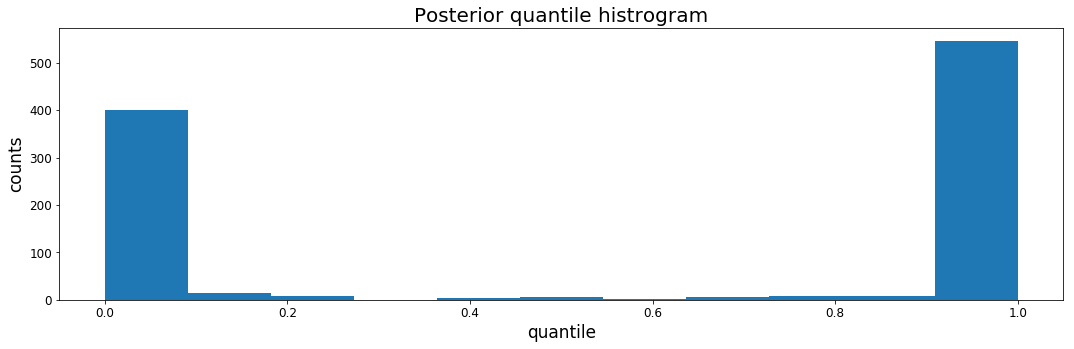

In [90]:
n, bins, patches = plt.hist(qis, bins='auto')
plt.title('Posterior quantile histrogram')
plt.xlabel('quantile')
plt.ylabel('counts')
n

# Now the continuous model parameter posterior

In [91]:
d_param_posterior = d['param_post']
d_param_posterior.keys()

dict_keys(['seed', 'trainer', 'params_mdn', 'x', 'y', 'sx', 'x_test', 'sx_test', 'y_test', 'training_norm', 'prior_norm', 'theta1', 'theta2', 'theta3', 'k1', 'k2', 'k3', 'sample_size', 'n_samples', 'qis'])

In [92]:
params_posterior_mdn = d_param_posterior['params_mdn']
training_norm = d_param_posterior['training_norm']
prior_norm = d_param_posterior['prior_norm']
seed = d_param_posterior['seed']
sample_size = d_param_posterior['sample_size']

## Sample new test data 

In [93]:
ntest = 1000
prior_lambda = scipy.stats.gamma(a=k1, scale=theta1)
params_test = prior_lambda.rvs(size=ntest)
poisson_model = PoissonModel(sample_size=sample_size, seed=seed, n_workers=1)
x_test = poisson_model.gen(params_test)

In [94]:
sx_test = calculate_stats_toy_examples(x_test)
sx_test_zt, _ = normalize(sx_test, training_norm)
params_test_zt, _ = normalize(params_test, prior_norm)

## Loop over test samples for 
- #### Quantiles 
- #### posterior mean differences 
- #### $D_{KL}$
- #### credible intervals 

In [95]:
qis = np.zeros(ntest)
mus_hat = np.zeros_like(qis)
mus_exact = np.zeros_like(qis)
stds_hat = np.zeros_like(qis)
stds_exact = np.zeros_like(qis)
dkl_ratios = np.zeros_like(qis)
credible_intervals = np.arange(0.05, 1., 0.05)
success_counts = np.zeros_like(credible_intervals)

# for every test sample 
with tqdm.tqdm(total=ntest) as pbar: 
    for ii, (thetao_i, sxo_i, xo_i) in enumerate(zip(params_test, sx_test_zt, x_test)): 

        tic = time.time()
        # predict the posterior
        post_hat = params_posterior_mdn.predict(sxo_i.reshape(1, -1))
        # get dd object 
        post_hat_dd = post_hat.get_dd_object()
        # transform to original parameter range 
        post_hat_or = post_hat_dd.ztrans_inv(prior_norm[0], prior_norm[1])

        # get the mean 
        mus_hat[ii] = post_hat_or.mean
        stds_hat[ii] = post_hat_or.std

        # get the mean of the exact posterior 
        post_exact = poisson_model.get_exact_posterior(xo_i, k1, theta1)
        mus_exact[ii] = post_exact.mean()    
        stds_exact[ii] = post_exact.std()
        # DKL ratio
        dkl_ratios[ii] = calculate_dkl(post_exact, post_hat_or) / post_exact.entropy()

        # credible intervals success
        # calculate samples 
        success_counts += calculate_credible_intervals_success(thetao_i, calculate_ppf_from_samples, credible_intervals, 
                                                               args=[post_hat_or.gen(10000)])
        # get quantile of theta_o
        thetao_i_zt, _ = normalize(thetao_i, prior_norm)
        qis[ii] = post_hat.get_quantile(thetao_i_zt)
        pbar.update()

100%|██████████| 1000/1000 [01:56<00:00,  9.35it/s]


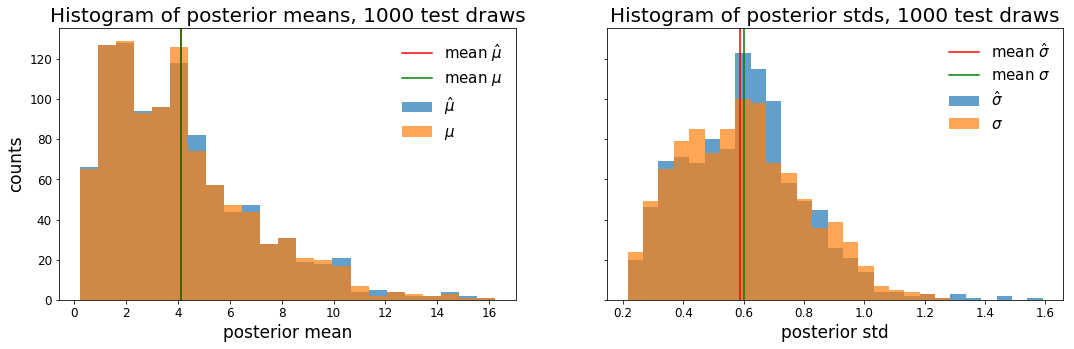

In [96]:
mean_diffs = mus_exact - mus_hat
std_diffs = stds_exact - stds_hat

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

n, bins, p = ax1.hist(mus_hat, bins='auto', label=r'$\hat{\mu}$', alpha=0.7)
ax1.hist(mus_exact, bins=bins, label=r'$\mu$', alpha=0.7)
ax1.set_title('Histogram of posterior means, {} test draws'.format(ntest))
ax1.axvline(x=mus_exact.mean(), label='mean $\hat{\mu}$', color='r');
ax1.axvline(x=mus_hat.mean(), label='mean $\mu$', color='g');
ax1.legend()
ax1.set_xlabel(r'posterior mean')
ax1.set_ylabel('counts');

n, bins, p = ax2.hist(stds_hat, bins='auto', label=r'$\hat{\sigma}$', alpha=0.7)
ax2.hist(stds_exact, bins=bins, label=r'$\sigma$', alpha=0.7)

ax2.set_title('Histogram of posterior stds, {} test draws'.format(ntest))

ax2.axvline(x=stds_exact.mean(), label='mean $\hat{\sigma}$', color='r');
ax2.axvline(x=stds_hat.mean(), label='mean $\sigma$', color='g');

ax2.legend()
ax2.set_xlabel(r'posterior std');

## Check Quantiles for Uniformity

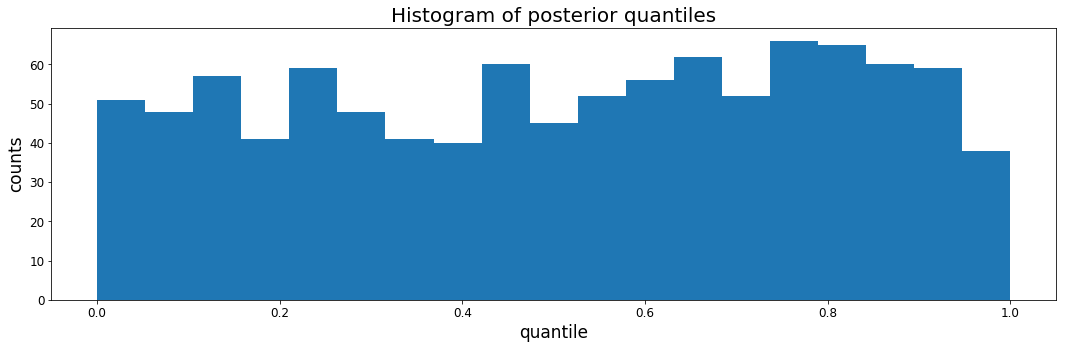

In [97]:
n, bins, patches = plt.hist(qis, bins=np.linspace(0, 1, 20))
plt.title('Histogram of posterior quantiles')
plt.xlabel('quantile')
plt.ylabel('counts');

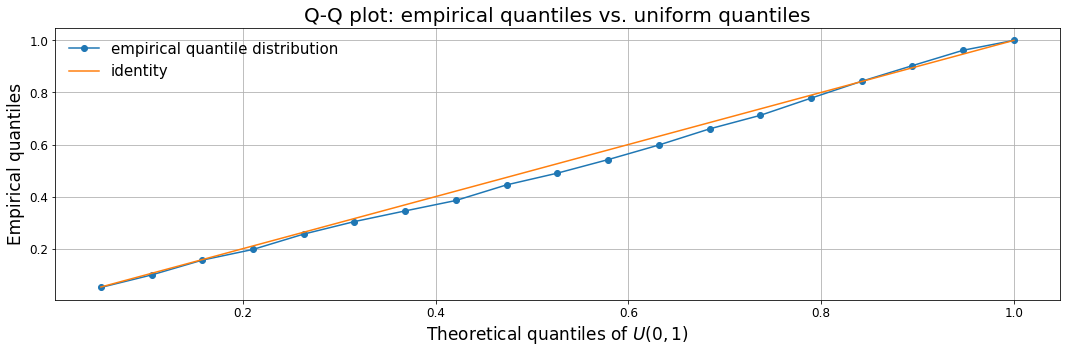

In [98]:
sample_quantiles = np.cumsum(n / np.sum(n))
theo_quantiles = np.cumsum(np.diff(bins))
plt.title('Q-Q plot: empirical quantiles vs. uniform quantiles')
plt.plot(theo_quantiles, sample_quantiles, 'o-', label='empirical quantile distribution')
plt.plot(theo_quantiles, theo_quantiles, label='identity')
plt.ylabel('Empirical quantiles')
plt.xlabel(r'Theoretical quantiles of $U(0, 1)$')
plt.legend()
plt.grid();

In [99]:
(stats, kst_p) = scipy.stats.kstest(qis, cdf='uniform')
kst_p

0.044701868143708801

## $D_{KL}$ check

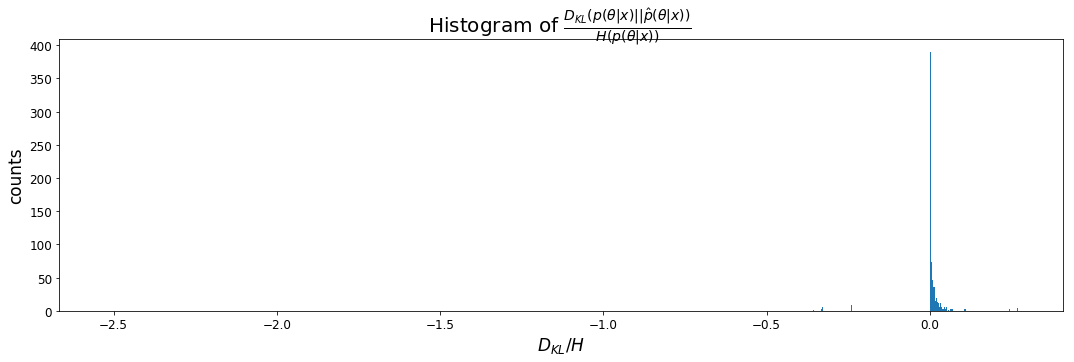

In [100]:
n, bins, patches = plt.hist(dkl_ratios, bins='auto')
plt.title(r'Histogram of $\frac{D_{KL}(p(\theta | x)||\hat{p}(\theta | x))}{ H(p(\theta | x))}$ ')
plt.xlabel(r'$D_{KL} / H$')
plt.ylabel('counts');

## Credible intervals
draw a $\theta$, get $sx$ and the posterior given $sx$, get the credible interval of different percentages, say 95 to 5 in steps of 5. 

The interval is defined as the equal-tailed interval, meaning that there is equal amount of mass below and above the interval. That is, to get the 90% credible interval take the 5% quantile and the 95% quantile as boundaries. 

Then, for each interval, check whether the true parameter falls into that interval and count a success, if yes. 

Repeat these steps many times to estimate the probability of the true parameter to fall into a corresponding credible interval. This probability should correspond to the corresponding amount mass in the interval. Thus, plotting the estimated probabilities against the interval values should give the identity line. 



In [101]:
# approximate interval success probability with relative frequency 
success_prob = success_counts / ntest

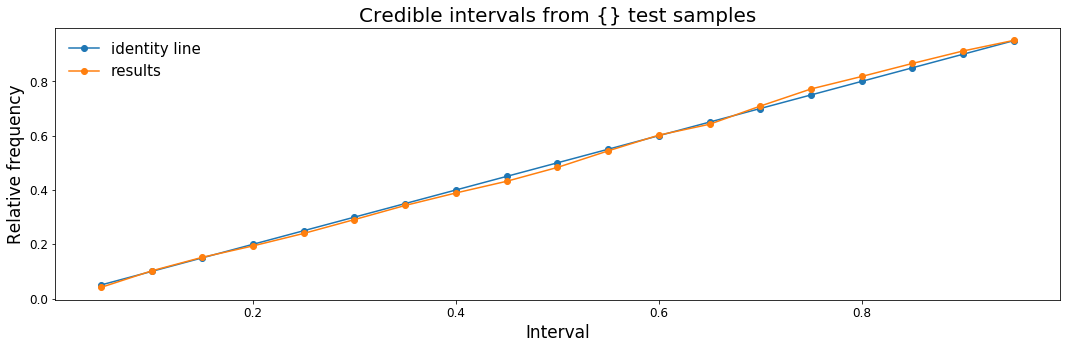

In [102]:
plt.title('Credible intervals from {} test samples')
plt.plot(credible_intervals, credible_intervals, 'o-', label='identity line')
plt.plot(credible_intervals, success_prob, 'o-', label='results')
plt.xlabel('Interval')
plt.ylabel('Relative frequency')
plt.legend();
# plt.tight_layout()

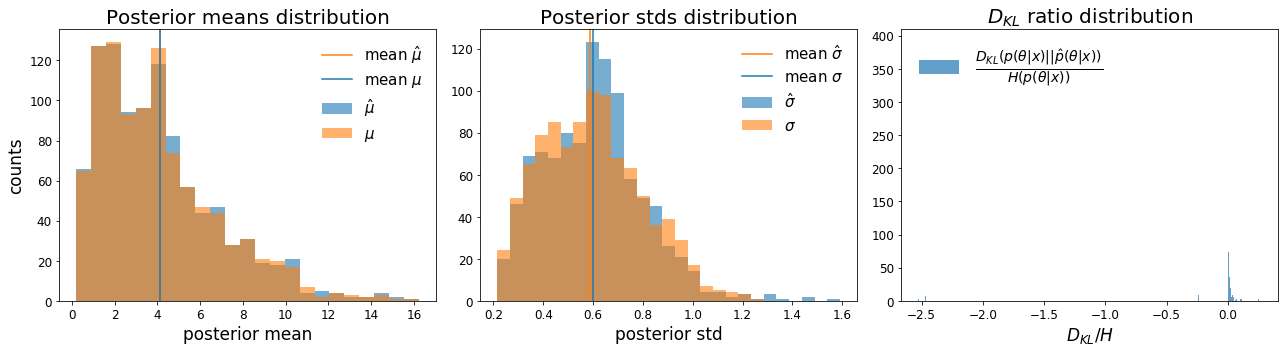

In [103]:
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(18, 5))
axes = axes.reshape(1, -1)
n, bins, p = axes[0, 0].hist(mus_hat, bins='auto', label=r'$\hat{\mu}$', alpha=0.6)
axes[0, 0].hist(mus_exact, bins=bins, label=r'$\mu$', alpha=0.6)
axes[0, 0].set_title('Posterior means distribution'.format(ntest))
axes[0, 0].axvline(x=mus_exact.mean(), label='mean $\hat{\mu}$', color='C1');
axes[0, 0].axvline(x=mus_hat.mean(), label='mean $\mu$', color='C0');
axes[0, 0].legend()
axes[0, 0].set_xlabel(r'posterior mean')
axes[0, 0].set_ylabel('counts');

n, bins, p = axes[0, 1].hist(stds_hat, bins='auto', label=r'$\hat{\sigma}$', alpha=0.6)
axes[0, 1].hist(stds_exact, bins=bins, label=r'$\sigma$', alpha=0.6)

axes[0, 1].set_title('Posterior stds distribution'.format(ntest))

axes[0, 1].axvline(x=stds_exact.mean(), label='mean $\hat{\sigma}$', color='C1');
axes[0, 1].axvline(x=stds_hat.mean(), label='mean $\sigma$', color='C0');

axes[0, 1].legend()
axes[0, 1].set_xlabel(r'posterior std')

n, bins, patches = axes[0, 2].hist(dkl_ratios, bins='auto', alpha=0.7,
                                   label=r'$\frac{D_{KL}(p(\theta | x)||\hat{p}(\theta | x))}{ H(p(\theta | x))}$')
# axes[0, 2].set_title(r'Histogram of $\frac{D_{KL}(p(\theta | x)||\hat{p}(\theta | x))}{ H(p(\theta | x))}$ ')
axes[0, 2].set_title(r'$D_{KL}$ ratio distribution')
axes[0, 2].set_xlabel(r'$D_{KL} / H$')
axes[0, 2].legend(fontsize=20)

plt.tight_layout();

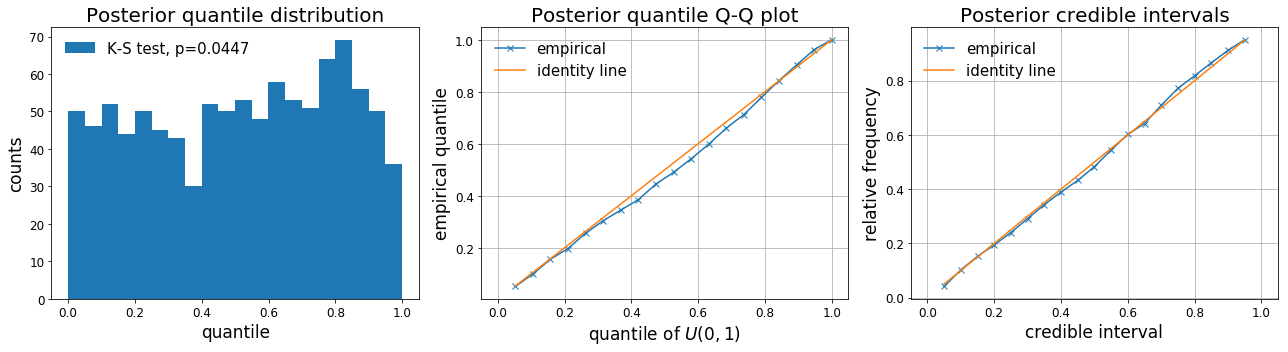

In [104]:
fig2, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
n, bins, patches = ax[0].hist(qis, bins=20, label='K-S test, p={:1.3}'.format(kst_p))
ax[0].set_title('Posterior quantile distribution')
ax[0].set_xlabel('quantile')
ax[0].set_ylabel('counts')
ax[0].legend()

ax[1].set_title('Posterior quantile Q-Q plot')
ax[1].plot(theo_quantiles, sample_quantiles, 'x-', label='empirical')
ax[1].plot(theo_quantiles, theo_quantiles, label='identity line')
ax[1].set_ylabel('empirical quantile')
ax[1].set_xlabel(r'quantile of $U(0, 1)$')
ax[1].legend()
ax[1].grid();

ax[2].set_title('Posterior credible intervals')
ax[2].plot(credible_intervals, success_prob, 'x-', label='empirical')
ax[2].plot(credible_intervals, credible_intervals, '-', label='identity line')
ax[2].set_ylabel('relative frequency')
ax[2].set_xlabel('credible interval')
ax[2].legend()
ax[2].grid();
plt.tight_layout();

In [105]:
figure_folder = '../figures'
fn = time_stamp + 'posterior_checks_1_k2_{}.png'.format(int(k2))
fig.savefig(os.path.join(figure_folder, fn), dpi=300)

In [106]:
fn = time_stamp + 'posterior_checks_2_k2_{}.png'.format(int(k2))
fig2.savefig(os.path.join(figure_folder, fn), dpi=300)